<a href="https://colab.research.google.com/github/prateekmanral011/Earthquake-forecasting/blob/main/mainshock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd
import numpy as np
from datetime import timedelta
from geopy.distance import geodesic

# === Load your earthquake catalog ===
# Replace with your CSV or data format
# Must have: Date, Latitude, Longitude, Magnitude
df = pd.read_csv('all_homo.csv')  # Upload in Colab
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

# === Define Gardner & Knopoff Time and Space Windows ===
# Magnitude bins with corresponding time (days) and distance (km) windows
windows = [
    (5.0, 5.5, 223, 43.5),
    (5.5, 6.0, 400, 51),
    (6.0, 6.5, 680, 58),
    (6.5, 7.0, 883, 66),
    (7.0, 7.5, 938, 76),
    (7.5, 8.0, 973, 88),
    (8.0, 8.5, 1006, 102)
    (8.5, 9.2, 1065, 130)
]

def get_window(mag):
    for mag_min, mag_max, t_win, d_win in windows:
        if mag_min <= mag < mag_max:
            return t_win, d_win
    return 0, 0  # No window for M < 5.0

# === Apply Declustering ===
declustered_indices = []
used = np.zeros(len(df), dtype=bool)

for i, row in df.iterrows():
    if used[i]:
        continue

    # Keep this as a mainshock
    declustered_indices.append(i)
    mag = row['Magnitude']
    date = row['Date']
    lat = row['Latitude']
    lon = row['Longitude']

    # Get time/distance window
    t_win, d_win = get_window(mag)
    if t_win == 0:
        continue

    # Define time range
    t_start = date
    t_end = date + timedelta(days=t_win)

    # Check all subsequent events
    for j in range(i+1, len(df)):
        if df.loc[j, 'Date'] > t_end:
            break
        if used[j]:
            continue
        dist = geodesic((lat, lon), (df.loc[j, 'Latitude'], df.loc[j, 'Longitude'])).km
        if dist <= d_win:
            used[j] = True  # Mark as aftershock

# === Final Mainshock Catalog ===
mainshocks_df = df.loc[declustered_indices].reset_index(drop=True)
mainshocks_df.to_csv('mainshocks_catalog.csv', index=False)

print("Total earthquakes:", len(df))
print("Mainshocks identified:", len(mainshocks_df))
mainshocks_df.head()


<>:22: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
<>:22: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?


ValueError: time data "2024-05-29 13:13:27+00:00" doesn't match format "%Y-%m-%d %H:%M:%S.%f%z", at position 86. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from geopy.distance import geodesic

# Load CSV
df = pd.read_csv('/content/all_homo.csv')  # Replace with actual path
df['Date'] = pd.to_datetime(df['Date'], format='mixed')
df = df.sort_values(by='Date').reset_index(drop=True)

# Gardner and Knopoff time-space window function (simplified)
def get_gk_window(mag):
    # (time window in days, space window in km)
    if mag < 5.0:
        return 0, 0
    elif mag < 5.5:
        return 11, 10
    elif mag < 6.0:
        return 22, 20
    elif mag < 6.5:
        return 32, 30
    elif mag < 7.0:
        return 45, 40
    elif mag < 7.5:
        return 90, 50
    elif mag < 8.0:
        return 180, 60
    else:
        return 365, 100

# Declustering
used = np.zeros(len(df), dtype=bool)
mainshocks = []

for i, row in df.iterrows():
    if used[i]:
        continue
    mainshocks.append(i)
    mag = row['Mw']
    origin = (row['latitude'], row['longitude'])
    time_win, dist_win = get_gk_window(mag)
    t_start = row['Date']
    t_end = t_start + timedelta(days=time_win)

    for j in range(i+1, len(df)):
        if used[j]:
            continue
        other_time = df.loc[j, 'Date']
        if other_time > t_end:
            break  # Outside time window
        other_loc = (df.loc[j, 'latitude'], df.loc[j, 'longitude'])
        distance = geodesic(origin, other_loc).km
        if distance <= dist_win:
            used[j] = True  # Mark as aftershock/foreshock

# Output
mainshock_df = df.loc[mainshocks].reset_index(drop=True)
aftershock_df = df[used].reset_index(drop=True)

# Save outputs
#mainshock_df.to_csv('/content/andaman_3.csv', index=False)
#aftershock_df.to_csv('/content/andaman_3.csv', index=False)

print(f"✅ Total mainshocks: {len(mainshock_df)}")
print(f"✅ Total aftershocks/foreshocks: {len(aftershock_df)}")


✅ Total mainshocks: 5551
✅ Total aftershocks/foreshocks: 1575


In [ ]:
import pandas as pd
import numpy as np
from geopy.distance import geodesic

# Load CSV (replace with your actual file path)
df = pd.read_csv("/content/burma_a1.csv")  # e.g. burma_all_mainshocks_homogenised_Mw.csv
df['date'] = pd.to_datetime(df['date'])

# Sort descending by magnitude
df = df.sort_values(by='Mw', ascending=False).reset_index(drop=True)

# Gardner & Knopoff window function (time in days, space in km)
def gk_window(mw):
    if mw < 5.0:
        return 10, 10
    elif mw < 5.5:
        return 22, 15
    elif mw < 6.0:
        return 30, 20
    elif mw < 6.5:
        return 50, 30
    elif mw < 7.0:
        return 100, 50
    elif mw < 7.5:
        return 150, 70
    elif mw < 8.0:
        return 200, 100
    else:
        return 240, 120

# Decluster: identify mainshocks
used = np.zeros(len(df), dtype=bool)
mainshock_indices = []

for i, row in df.iterrows():
    if used[i]:
        continue
    mainshock_indices.append(i)
    main_time = row['date']
    main_loc = (row['latitude'], row['longitude'])
    main_mag = row['Mw']
    time_win, space_win = gk_window(main_mag)

    for j in range(i + 1, len(df)):
        if used[j]:
            continue
        other_time = df.loc[j, 'date']
        other_loc = (df.loc[j, 'latitude'], df.loc[j, 'longitude'])
        time_diff = (other_time - main_time).days
        space_diff = geodesic(main_loc, other_loc).km

        if 0 < time_diff <= time_win and space_diff <= space_win:
            used[j] = True


# Output: Include date, Mw, latitude, longitude
mainshocks = df.loc[mainshock_indices][['date', 'Mw', 'latitude', 'longitude']].copy()
mainshocks.to_csv("/content/burma_A2.csv", index=False)

print("✅ Mainshocks file saved with columns: date, Mw, latitude, and longitude")

from google.colab import files
files.download("/content/burma_A2.csv")



/tmp/ipython-input-2-2743590631.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date'])


✅ Mainshocks file saved with columns: date, Mw, latitude, and longitude


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from geopy.distance import geodesic

# Sample data (you can replace this with your CSV import)
data = [
    ["12/26/04", 5.499, 94.213, 6.15],
    ["12/26/04", 6.34, 93.361, 6.15],
    ["12/26/04", 6.848, 94.667, 6.04],
    ["12/26/04", 6.91, 92.958, 7.2],
    ["12/26/04", 7.421, 93.985, 6.04],
    ["12/26/04", 8.879, 92.375, 6.6],
    ["12/26/04", 13.462, 92.738, 6.3],
    ["12/26/04", 13.533, 92.84, 6.2],
    ["12/29/04", 8.791, 93.198, 6.2],
    ["12/29/04", 9.109, 93.756, 6.1],
    ["12/31/04", 6.204, 92.913, 6.0],
    ["12/31/04", 7.12, 92.533, 6.1],
    ["1/1/05", 7.336, 94.455, 6.1],
    ["1/2/05", 6.36, 92.787, 6.4],
    ["1/4/05", 10.672, 92.362, 6.1]
]

# Convert to DataFrame
df = pd.DataFrame(data, columns=["date", "latitude", "longitude", "Mw"])
df["date"] = pd.to_datetime(df["date"], format="%m/%d/%y")
df = df.sort_values("Mw", ascending=False).reset_index(drop=True)

# Gardner & Knopoff (1974) window function
def gk_window(mag):
    if mag < 5.0:
        return 0, 0
    elif mag < 5.5:
        return 10, 7
    elif mag < 6.0:
        return 15, 10
    elif mag < 6.5:
        return 22, 12
    elif mag < 7.0:
        return 35, 15
    elif mag < 7.5:
        return 50, 20
    elif mag < 8.0:
        return 75, 25
    else:
        return 100, 30

# Decluster using Gardner & Knopoff
used = np.zeros(len(df), dtype=bool)
mainshocks = []

for i, row in df.iterrows():
    if used[i]:
        continue
    mainshocks.append(i)
    mag = row["Mw"]
    time = row["date"]
    loc1 = (row["latitude"], row["longitude"])
    days, km = gk_window(mag)

    for j in range(i + 1, len(df)):
        if used[j]:
            continue
        tdiff = (df.loc[j, "date"] - time).days
        loc2 = (df.loc[j, "latitude"], df.loc[j, "longitude"])
        dist = geodesic(loc1, loc2).km
        if 0 <= tdiff <= days and dist <= km:
            used[j] = True

# Extract mainshocks
mainshock_df = df.loc[mainshocks][["date", "Mw"]].sort_values("date").reset_index(drop=True)

# Show result
mainshock_df


,date,Mw
0,2004-12-26,7.20
1,2004-12-26,6.60
2,2004-12-26,6.30
3,2004-12-26,6.20
4,2004-12-26,6.15
5,2004-12-26,6.15
6,2004-12-26,6.04
7,2004-12-26,6.04
8,2004-12-29,6.20
9,2004-12-29,6.10


In [ ]:
##condition of aftershock and mainshock fulfilled or not not known
import pandas as pd
import numpy as np
from datetime import timedelta
from geopy.distance import geodesic

# === Load Earthquake Catalog ===
df = pd.read_csv('/content/all_homo.csv')
df.columns = df.columns.str.strip()
df['Date'] = pd.to_datetime(df['Date'], format='mixed')
df = df.rename(columns={'Mw': 'Magnitude'})  # internal naming consistency
df = df.sort_values('Date').reset_index(drop=True)

# === Gardner & Knopoff Time and Space Windows ===
windows = [
    (5.0, 5.5, 223, 43.5),
    (5.5, 6.0, 400, 51),
    (6.0, 6.5, 680, 58),
    (6.5, 7.0, 883, 66),
    (7.0, 7.5, 938, 76),
    (7.5, 8.0, 973, 88),
    (8.0, 8.5, 1006, 102),
    (8.5, 9.2, 1065, 130)
]

def get_window(mag):
    for mag_min, mag_max, t_win, d_win in windows:
        if mag_min <= mag < mag_max:
            return t_win, d_win
    return 0, 0  # Ignore events < M5.0

# === Declustering Process ===
declustered_indices = []
used = np.zeros(len(df), dtype=bool)
aftershock_indices = []

for i, row in df.iterrows():
    if used[i]:
        continue

    # Mark as mainshock
    declustered_indices.append(i)
    mag = row['Magnitude']
    date = row['Date']
    lat = row['latitude']
    lon = row['longitude']

    t_win, d_win = get_window(mag)
    if t_win == 0:
        continue

    t_end = date + timedelta(days=t_win)

    for j in range(i + 1, len(df)):
        if df.loc[j, 'Date'] > t_end:
            break
        if used[j]:
            continue
        dist = geodesic((lat, lon), (df.loc[j, 'latitude'], df.loc[j, 'longitude'])).km
        if dist <= d_win:
            used[j] = True
            aftershock_indices.append(j)

# === Build Mainshock and Aftershock DataFrames ===
mainshocks_df = df.loc[declustered_indices].reset_index(drop=True)
aftershocks_df = df.loc[aftershock_indices].reset_index(drop=True)

# === Rename column to match input format ===
mainshocks_df = mainshocks_df[['Date', 'latitude', 'longitude', 'Magnitude']].rename(columns={'Magnitude': 'Mw'})
aftershocks_df = aftershocks_df[['Date', 'latitude', 'longitude', 'Magnitude']].rename(columns={'Magnitude': 'Mw'})

# === Save to CSV ===
mainshocks_df.to_csv('mainshocks_catalog.csv', index=False)
aftershocks_df.to_csv('aftershocks_catalog.csv', index=False)

# === Print summary ===
print(f"✅ Total events in catalog: {len(df)}")
print(f"✅ Mainshocks identified: {len(mainshocks_df)}")
print(f"✅ Aftershocks identified: {len(aftershocks_df)}")
#print("\n📄 Mainshocks preview:")
#print(mainshocks_df.head())
#print("\n📄 Aftershocks preview:")
#print(aftershocks_df.head())
from google.colab import files

# Download both files
files.download('mainshocks_catalog.csv')
files.download('aftershocks_catalog.csv')


✅ Total events in catalog: 7126
✅ Mainshocks identified: 4017
✅ Aftershocks identified: 3109


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Total events in catalog: 7126
✅ Mainshocks identified: 4349
✅ Aftershocks identified: 2777


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

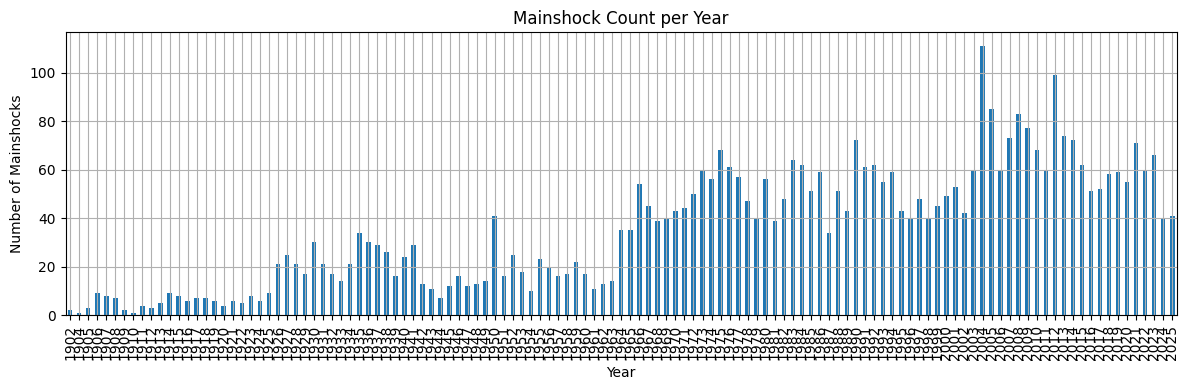

In [ ]:
##best till now i get , here also applying condition of mainshock>aftershock above not applied but still in a single year a lot of earthquakes can be seen
import pandas as pd
import numpy as np
from datetime import timedelta
from geopy.distance import geodesic

# === Load Earthquake Catalog ===
df = pd.read_csv('/content/all_homo.csv')
df.columns = df.columns.str.strip()
df['Date'] = pd.to_datetime(df['Date'], format='mixed')
df = df.rename(columns={'Mw': 'Magnitude'})  # internal consistency
df = df.sort_values('Date').reset_index(drop=True)

# === Gardner & Knopoff Time and Space Windows (days, km) ===
windows = [
    (5.0, 5.5, 223, 43.5),
    (5.5, 6.0, 400, 51),
    (6.0, 6.5, 680, 58),
    (6.5, 7.0, 883, 66),
    (7.0, 7.5, 938, 76),
    (7.5, 8.0, 973, 88),
    (8.0, 8.5, 1006, 102),
    (8.5, 9.2, 1065, 130)
]

def get_window(mag):
    for mag_min, mag_max, t_win, d_win in windows:
        if mag_min <= mag < mag_max:
            return t_win, d_win
    return 0, 0  # Events with mag < 5.0 will be ignored

# === Declustering Process ===
declustered_indices = []
used = np.zeros(len(df), dtype=bool)
aftershock_indices = []

for i, row in df.iterrows():
    if used[i]:
        continue

    mag = row['Magnitude']
    if mag < 5.0:
        continue  # Ignore events below threshold

    # Mark as mainshock
    declustered_indices.append(i)
    date = row['Date']
    lat = row['latitude']
    lon = row['longitude']

    t_win, d_win = get_window(mag)
    t_end = date + timedelta(days=t_win)

    for j in range(i + 1, len(df)):
        if df.loc[j, 'Date'] > t_end:
            break
        if used[j]:
            continue

        # Compute distance and magnitude condition
        dist = geodesic((lat, lon), (df.loc[j, 'latitude'], df.loc[j, 'longitude'])).km
        if dist <= d_win and df.loc[j, 'Magnitude'] < mag:
            used[j] = True
            aftershock_indices.append(j)

# === Build Final DataFrames ===
mainshocks_df = df.loc[declustered_indices].reset_index(drop=True)
aftershocks_df = df.loc[aftershock_indices].reset_index(drop=True)

# === Format Columns for Output Consistency ===
mainshocks_df = mainshocks_df[['Date', 'latitude', 'longitude', 'Magnitude']].rename(columns={'Magnitude': 'Mw'})
aftershocks_df = aftershocks_df[['Date', 'latitude', 'longitude', 'Magnitude']].rename(columns={'Magnitude': 'Mw'})

# === Save to CSV Files ===
mainshocks_df.to_csv('mainshocks_catalog_1.csv', index=False)
aftershocks_df.to_csv('aftershocks_catalog_1.csv', index=False)

# === Print Summary ===
print(f"✅ Total events in catalog: {len(df)}")
print(f"✅ Mainshocks identified: {len(mainshocks_df)}")
print(f"✅ Aftershocks identified: {len(aftershocks_df)}")

from google.colab import files

# Download both files
files.download('mainshocks_catalog_1.csv')
files.download('aftershocks_catalog_1.csv')

import matplotlib.pyplot as plt

mainshocks_df['year'] = mainshocks_df['Date'].dt.year
counts = mainshocks_df.groupby('year').size()
counts.plot(kind='bar', figsize=(12, 4), title='Mainshock Count per Year')
plt.xlabel('Year')
plt.ylabel('Number of Mainshocks')
plt.grid(True)
plt.tight_layout()
plt.show()
